<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/7_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this final step of the research, we use the best model (XGBoost) to make predictions on unknown future data.

To illustrate the results of our research, we estimate future traffic flow only in the first 20 paths of the dataset.

Remember: the data that were used had been recorded within the following time interval: **[2008-05-17 10:00:04, 2008-05-30 00:00:04]**. Now, we will forecast traffic flow on each path from **2008-05-30 00:00:04** and onwards.

In [34]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import Google Drive
from google.colab import drive

In [35]:
# Access Google Drive, as we will read files from the cloud
drive.mount('/content/drive')

# Define the path with the time series SPQ data
traffic_data = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_SPQ.csv'

# Read dataset
time_series = pd.read_csv(traffic_data,nrows=20)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocess traffic flow data

In [36]:
# This list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# Generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-30 00:00:04')):
        break

    i+=1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframe
time_series.columns = columns

# Generate new time columns for the dataseT
dates = []
i = 0
while(True):
    if i == 0:
        dates.append(columns[-1] + timedelta(seconds=1800))
    else:
        dates.append(dates[i-1] + timedelta(seconds=1800))

    if (dates[i] == pd.to_datetime('2008-05-30 12:00:04')):
        break

    i+=1

# Add new columns to dataset
for value in dates:
    column_name = str(value)
    time_series[column_name] = -1

id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns

# Reshape the data from wide format to long format using pandas melt function
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# Change time column to datetime format
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# Sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

# Convert path column from categorical to numerical using Label Encoder library
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# Sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# Define new index for traffic flow data
time_series.set_index('Time Column', inplace=True)

# Create a copy of time series dataset
roudolf = time_series.copy()

In [37]:
# Show first rows of data
time_series.head(5)

,Taxi ID,Traj ID,Path,Length,Traffic Flow
Time Column,,,,,
2008-05-17 10:00:04,262,190,0,6,6
2008-05-17 10:30:04,262,190,0,6,5
2008-05-17 11:00:04,262,190,0,6,5
2008-05-17 11:30:04,262,190,0,6,1
2008-05-17 12:00:04,262,190,0,6,2


Preprocess weather data

In [38]:
# Define path to weather data
weather_path = '/content/drive/MyDrive/Paper/Datasets/Weather Data/weather_data.csv'

# Read weather data
weather_data = pd.read_csv(weather_path,sep=',')

# Drop unecessary columns
weather_data = weather_data[['datetime','temp','dew','windspeed','cloudcover']]

# Convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# Set time info as the index of the weather dataframe
weather_data.set_index('datetime', inplace=True)

# Resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# Add 4 seconds to each timestamp
weather_data.index = weather_data.index + pd.to_timedelta(4, unit='s')

# Merge the time_series and weather_data_resampled datasets based on their indexes
time_series = time_series.merge(weather_data, left_index=True, right_index=True)

# Change the index of time series
time_series = time_series.reset_index()
time_series.rename(columns={'index': 'Time Column'}, inplace=True)

In [39]:
# Plot first rows of dataframe
time_series.head(5)

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,dew,windspeed,cloudcover
0,2008-05-17 10:00:04,262,190,0,6,6,21.4,11.8,12.1,28.1
1,2008-05-17 10:00:04,45,32,1,14,5,21.4,11.8,12.1,28.1
2,2008-05-17 10:00:04,175,75,2,13,1,21.4,11.8,12.1,28.1
3,2008-05-17 10:00:04,183,9,3,15,1,21.4,11.8,12.1,28.1
4,2008-05-17 10:00:04,52,637,4,16,2,21.4,11.8,12.1,28.1


Add extra time-related features

In [40]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Extract Time Components
time_series['hour'] = time_series['Time Column'].dt.hour
time_series['dayofweek'] =time_series['Time Column'].dt.dayofweek
time_series['day'] = time_series['Time Column'].dt.day
time_series['minute'] = time_series['Time Column'].dt.minute

### Circular Encoding for Cyclic Time Features ###

# Encode hour as sine and cosine values to handle cyclic nature
time_series['hour_sin'] = np.sin(2 * np.pi * time_series['hour'] / 24)
time_series['hour_cos'] = np.cos(2 * np.pi * time_series['hour'] / 24)

# Encode day of the week as sine and cosine values to handle cyclic nature
time_series['day_of_week_sin'] = np.sin(2 * np.pi * time_series['dayofweek'] / 7)
time_series['day_of_week_cos'] = np.cos(2 * np.pi * time_series['dayofweek'] / 7)

# Encode day of the month as sine and cosine values to handle cyclic nature
time_series['day_sin'] = np.sin(2 * np.pi * time_series['day'] / 31)
time_series['day_cos'] = np.cos(2 * np.pi * time_series['day'] / 31)

# Encode minute as sine and cosine values to handle cyclic nature
time_series['minute_sin'] = np.sin(2 * np.pi * time_series['minute'] / 60)
time_series['minute_cos'] = np.cos(2 * np.pi * time_series['minute'] / 60)

# Apply the custom function on the data to create the '3hour_interval' column
time_series['3hour_interval'] = time_series['hour'].apply(get_3hour_interval)  # Make sure get_3hour_interval is defined

In [41]:
# Print first rows of dataset
time_series.head(5)

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,dew,windspeed,cloudcover,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,262,190,0,6,6,21.4,11.8,12.1,28.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
1,2008-05-17 10:00:04,45,32,1,14,5,21.4,11.8,12.1,28.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
2,2008-05-17 10:00:04,175,75,2,13,1,21.4,11.8,12.1,28.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
3,2008-05-17 10:00:04,183,9,3,15,1,21.4,11.8,12.1,28.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4
4,2008-05-17 10:00:04,52,637,4,16,2,21.4,11.8,12.1,28.1,...,0,0.5,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.0,1.0,4


Use the sliding window tecnique on the data

In [42]:
# Define sliding window method

from pandas import DataFrame
from pandas import concat

# Create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data,n_in=1,n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the culumns.
    """
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # Call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # The rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series[time_series['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

# Convert data to supervised problem (using sliding window) based in the optimum lookback step we defined in previous notebook.
# We found that the optimum window length is 5
# Remember: optimum length of sliding window proved to be number six.
time_series = generate_X_y_pairs(time_series,5)

# Reset index of dataframe
time_series.reset_index(drop=True,inplace=True)

In [43]:
# Print dataset
time_series.head()

,Traffic Flow 1(t-5),Traffic Flow 1(t-4),Traffic Flow 1(t-3),Traffic Flow 1(t-2),Traffic Flow 1(t-1),Traffic Flow 1(t),Time Column,Taxi ID,Traj ID,Path,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,6.0,5.0,5.0,1.0,2.0,4,2008-05-17 12:30:04,262,190,0,...,30,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,5
1,5.0,5.0,1.0,2.0,4.0,2,2008-05-17 13:00:04,262,190,0,...,0,-2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
2,5.0,1.0,2.0,4.0,2.0,4,2008-05-17 13:30:04,262,190,0,...,30,-2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,5
3,1.0,2.0,4.0,2.0,4.0,3,2008-05-17 14:00:04,262,190,0,...,0,-5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
4,2.0,4.0,2.0,4.0,3.0,10,2008-05-17 14:30:04,262,190,0,...,30,-5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,5


Make forecasts of traffic flow using the XGBoost model

In [44]:
# Import XGBoost library
import xgboost as xgb

# Define the path with the time series SPQ data
model_path = '/content/drive/MyDrive/Paper/Models/xgboost_traffic_flow.model'

# Load the saved XGBoost model
loaded_model = xgb.Booster(model_file=model_path)

In [45]:
# List with all the fututre timestamps
# Traffic flow at these unknown timestamps needs to be estimated
news = time_series[time_series['Time Column'] >= pd.to_datetime('2008-05-30 00:00:04')]['Time Column'].to_list()

# Loop over unique paths in the time series data
for path in time_series['Path'].unique():
  print('Data of path', path)

  # Loop over the future timestamps
  for time in news:
    # Select data for the specific path and time
    select = time_series[(time_series['Time Column'] == time) & (time_series.Path == path)]

    # Calculate rolling mean and rolling variance
    select['rolling_mean'] = select.iloc[:, 0:5].mean(axis=1)
    select['rolling_var'] = select.iloc[:, 0:5].var(axis=1)

    # Select only necessary features
    fit = select[['Traffic Flow 1(t-5)', 'Traffic Flow 1(t-4)', 'Traffic Flow 1(t-3)', 'Traffic Flow 1(t-2)',
       'Traffic Flow 1(t-1)', 'Path', 'temp', 'dew', 'windspeed', 'cloudcover',
       'hour_cos', 'day_of_week_sin', 'day_sin', 'day_cos', 'minute_sin',
       '3hour_interval', 'rolling_mean', 'rolling_var']]

    # Make predictions using the loaded XGBoost model
    x = loaded_model.predict(xgb.DMatrix(fit))

    # Convert predicted values to integers and update the 'Traffic Flow' column in 'roudolf'
    float_list = [int(round(float(value_str))) for value_str in x]
    roudolf.loc[(roudolf['Path'] == path) & (roudolf.index == time), 'Traffic Flow'] = float_list

    # Change the future values in 'time_series' dataframe. Forecasted value is now the current value,
    # while the others are sliding one position, on the left
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time),'Traffic Flow 1(t)'] = float_list
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-5)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-4)'].iloc[0]
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-4)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-3)'].iloc[0]
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-3)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-2)'].iloc[0]
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-2)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t-1)'].iloc[0]
    time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time+timedelta(seconds=1800)),'Traffic Flow 1(t-1)'] = time_series.loc[(time_series['Path']==path) & (time_series['Time Column'] == time)]['Traffic Flow 1(t)'].iloc[0]

Data of path 0
Data of path 1
Data of path 2
Data of path 3
Data of path 4
Data of path 5
Data of path 6
Data of path 7
Data of path 8
Data of path 9
Data of path 10
Data of path 11
Data of path 12
Data of path 13
Data of path 14
Data of path 15
Data of path 16
Data of path 17
Data of path 18
Data of path 19


Plot the results using graphs

In [47]:
import matplotlib.pyplot as plt

def plot_actual_predicted(p):
    """
    Plot actual and predicted traffic flow values with a division line.

    Parameters:
    p (int): The path value for which to plot the data.

    Returns:
    None
    """
    # Filter data for previous and forecasted periods
    previous_data = roudolf[(roudolf['Path'] == p) & (roudolf.index <= '2008-05-30 00:00:04')]
    forecast_data = roudolf[(roudolf['Path'] == p) & (roudolf.index >= '2008-05-30 00:00:04')]

    # Create the plot
    plt.figure(figsize=(15, 5))
    # Plot previous data
    previous_data['Traffic Flow'].plot(color='blue', label='Previous Values')
    # Plot forecast data
    forecast_data['Traffic Flow'].plot(color='orange', label='Forecasted Values')
    # Draw a division line
    plt.axvline(x='2008-05-30 00:00:04', alpha=0.8, color='gray', linestyle='--', label='Division Line')

    # Add titles
    plt.xlabel('Timestamp')
    plt.ylabel('Traffic Flow')
    plt.title('Traffic Flow Forecast in path with number ' + str(p))

    # Display legend
    plt.legend()

    # Show the plot
    plt.show()

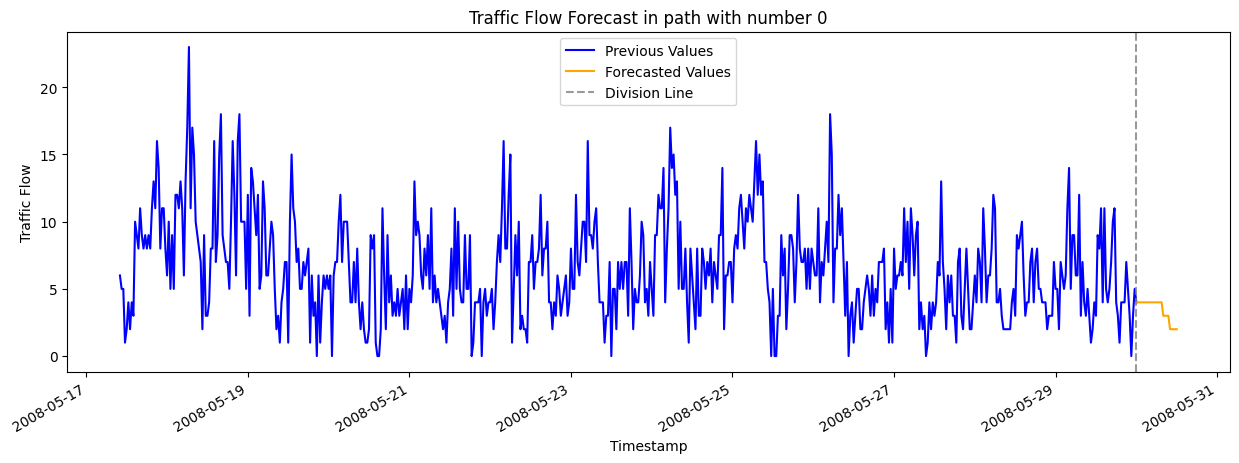

In [48]:
# Plot actual and predicted values of traffic flow in path with number 0
plot_actual_predicted(0)

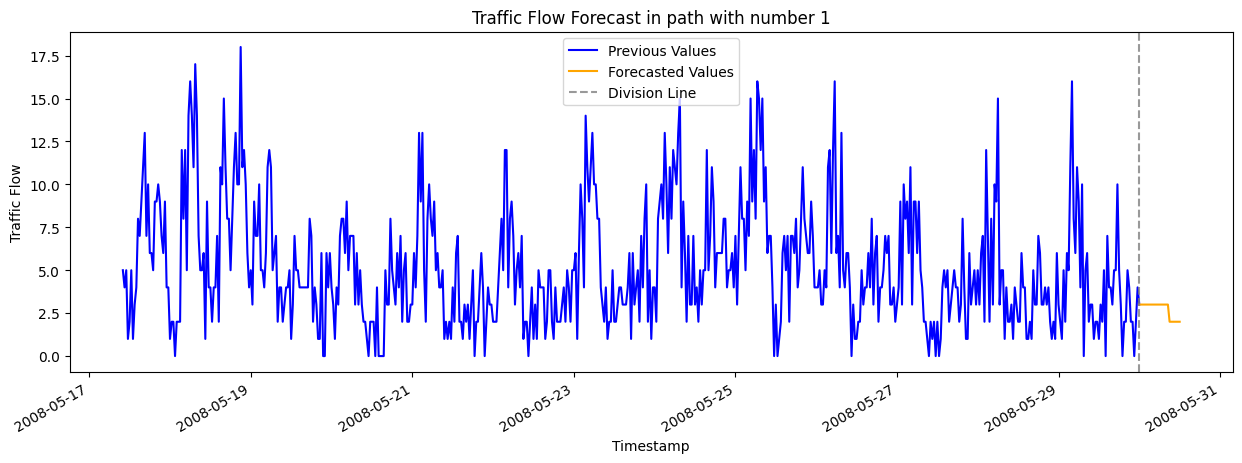

In [49]:
# Plot actual and predicted values of traffic flow in path with number 1
plot_actual_predicted(1)

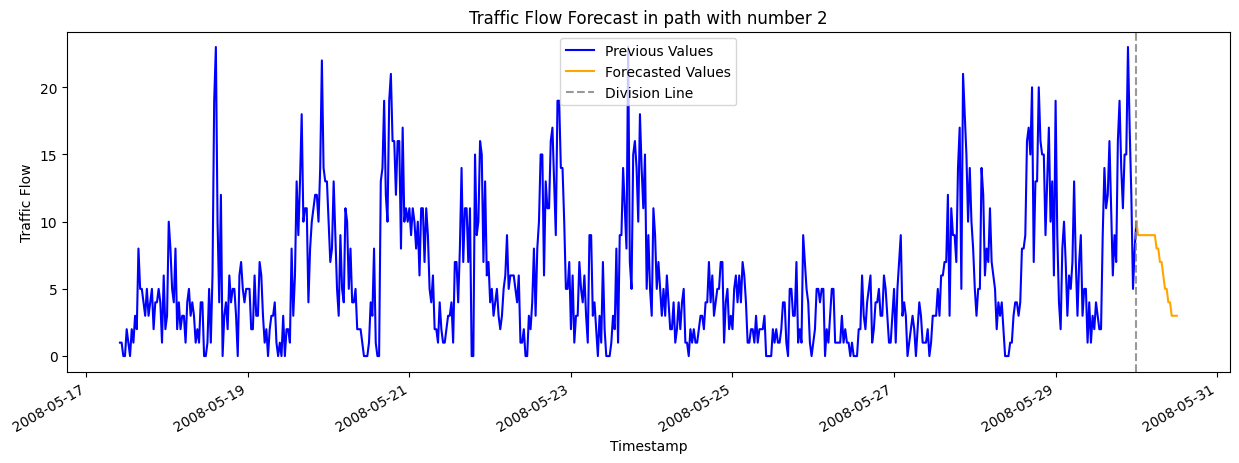

In [50]:
# Plot actual and predicted values of traffic flow in path with number 2
plot_actual_predicted(2)

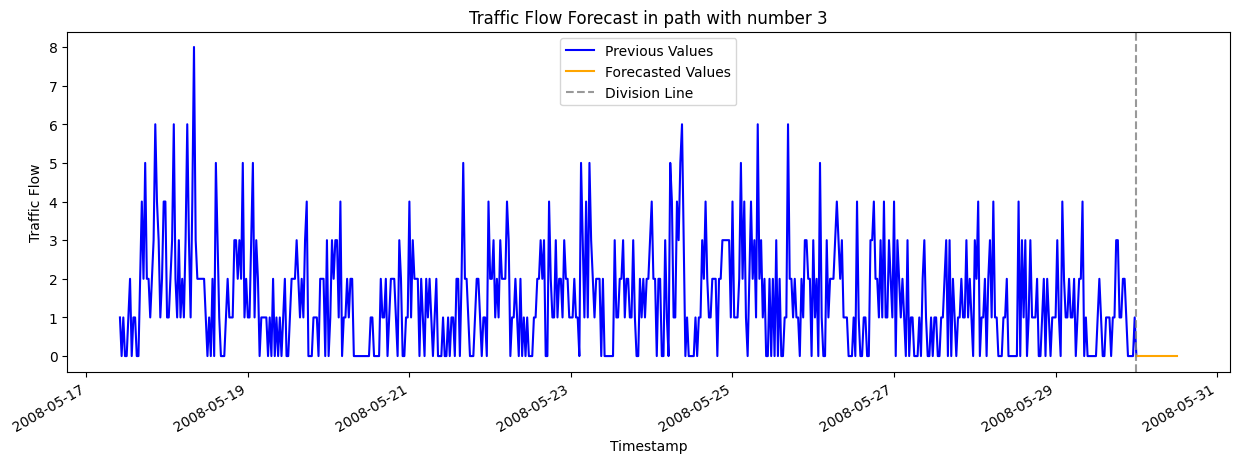

In [51]:
# Plot actual and predicted values of traffic flow in path with number 3
plot_actual_predicted(3)

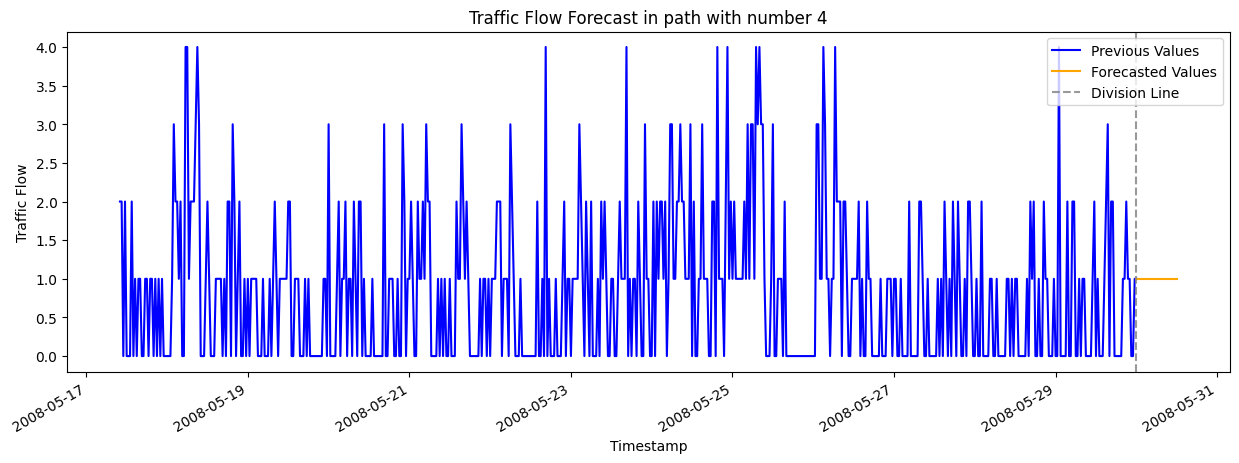

In [52]:
# Plot actual and predicted values of traffic flow in path with number 4
plot_actual_predicted(4)

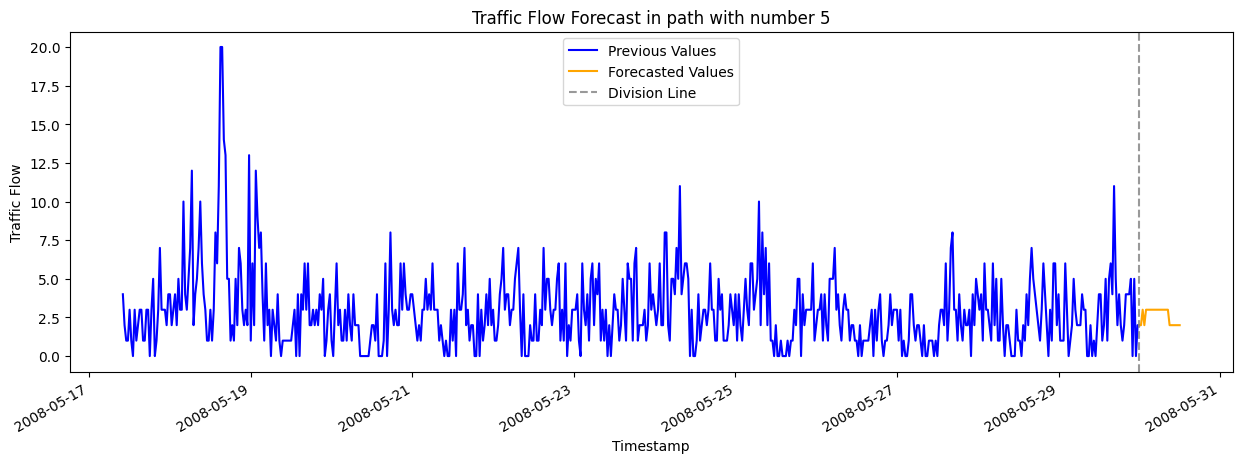

In [53]:
# Plot actual and predicted values of traffic flow in path with number 5
plot_actual_predicted(5)

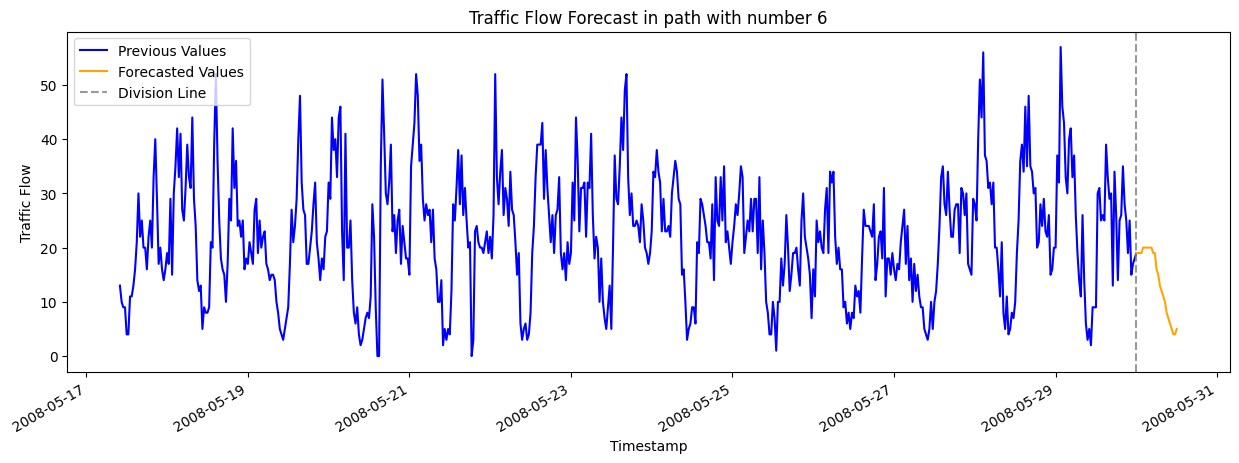

In [54]:
# Plot actual and predicted values of traffic flow in path with number 6
plot_actual_predicted(6)

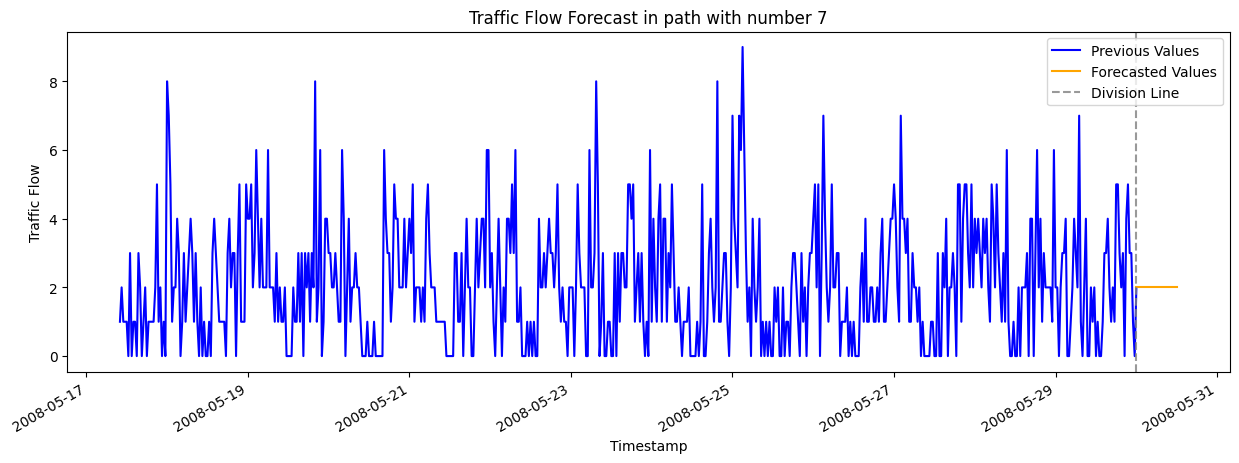

In [55]:
# Plot actual and predicted values of traffic flow in path with number 7
plot_actual_predicted(7)

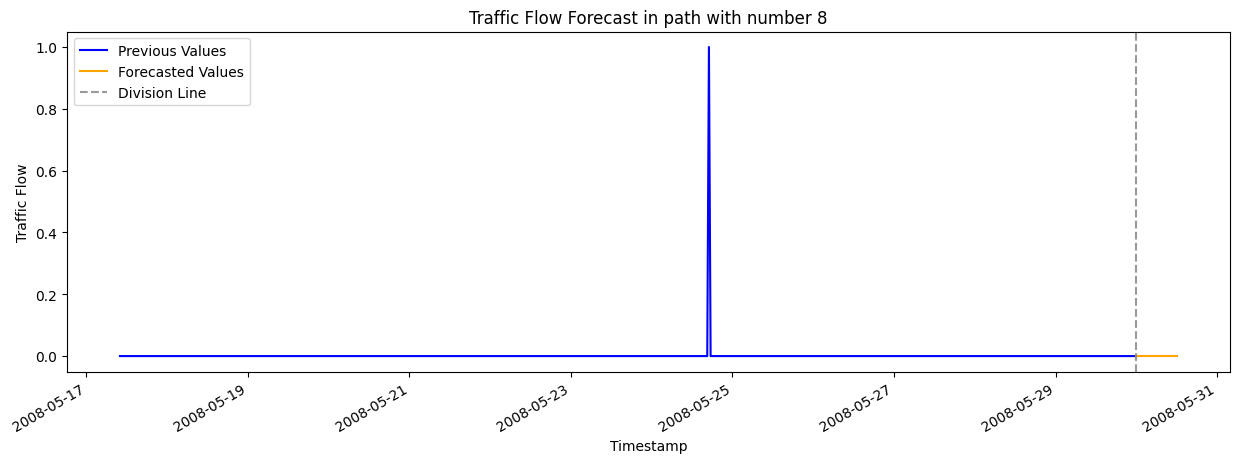

In [56]:
# Plot actual and predicted values of traffic flow in path with number 8
plot_actual_predicted(8)

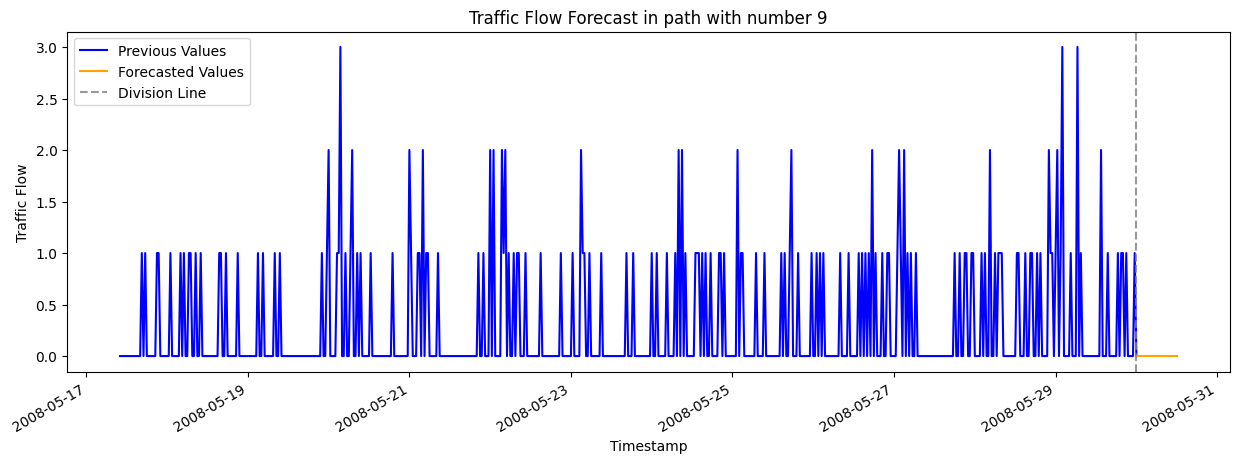

In [57]:
# Plot actual and predicted values of traffic flow in path with number 9
plot_actual_predicted(9)

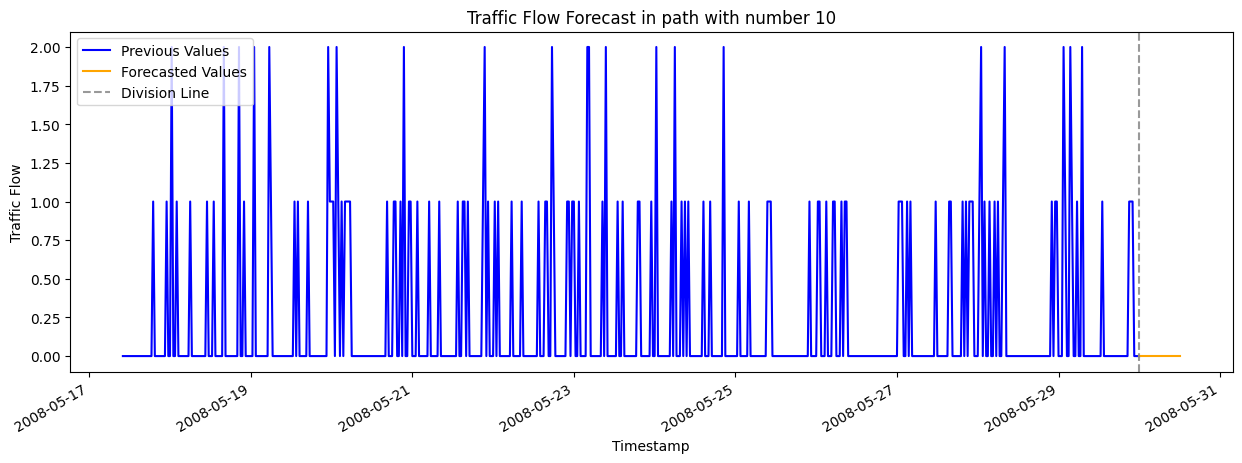

In [58]:
# Plot actual and predicted values of traffic flow in path with number 10
plot_actual_predicted(10)

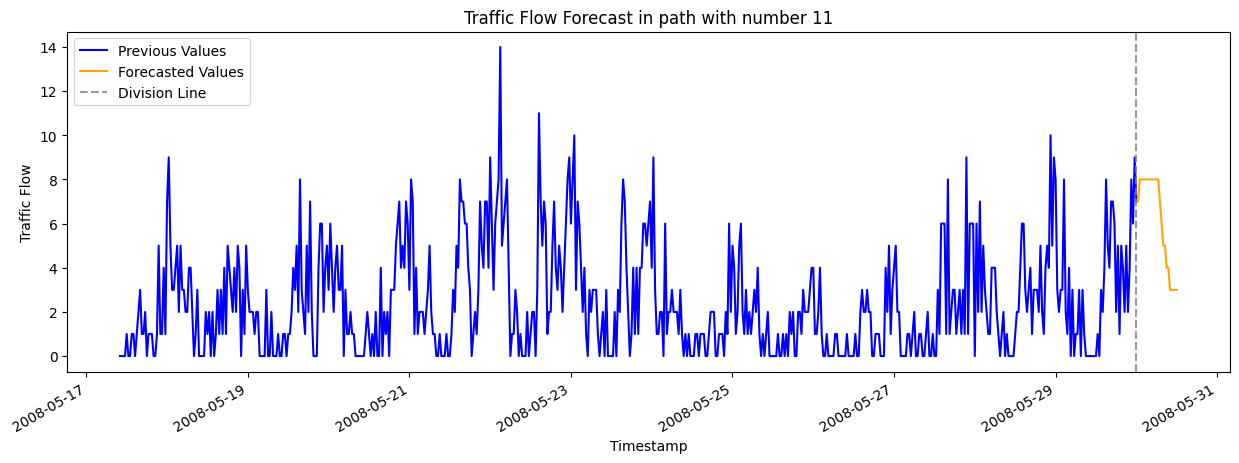

In [59]:
# Plot actual and predicted values of traffic flow in path with number 11
plot_actual_predicted(11)

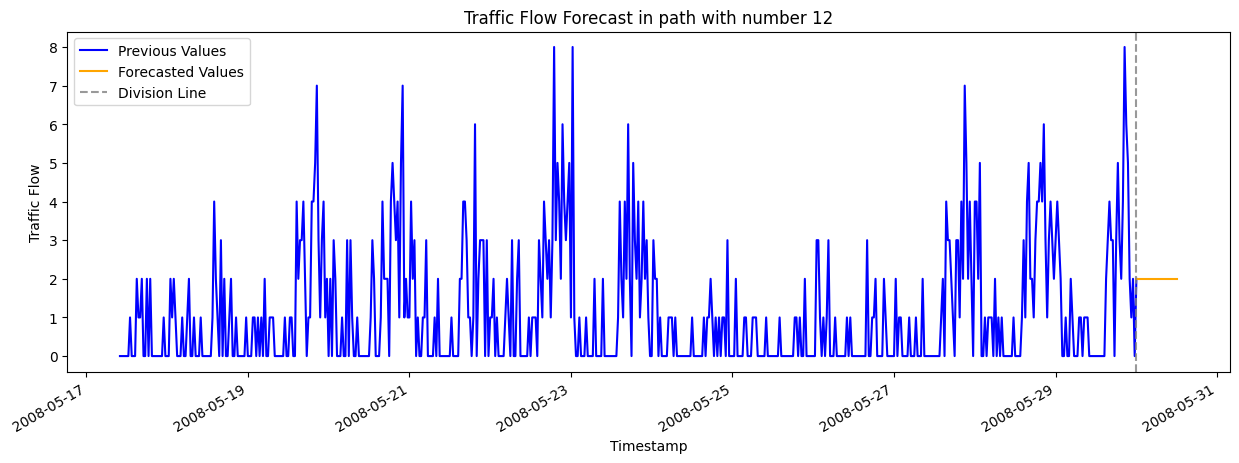

In [60]:
# Plot actual and predicted values of traffic flow in path with number 12
plot_actual_predicted(12)

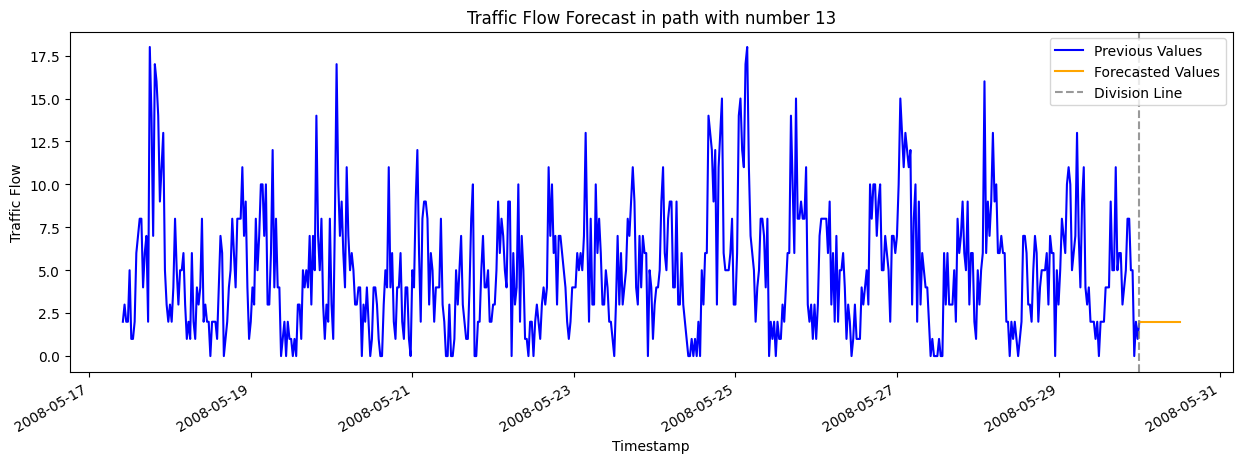

In [61]:
# Plot actual and predicted values of traffic flow in path with number 13
plot_actual_predicted(13)

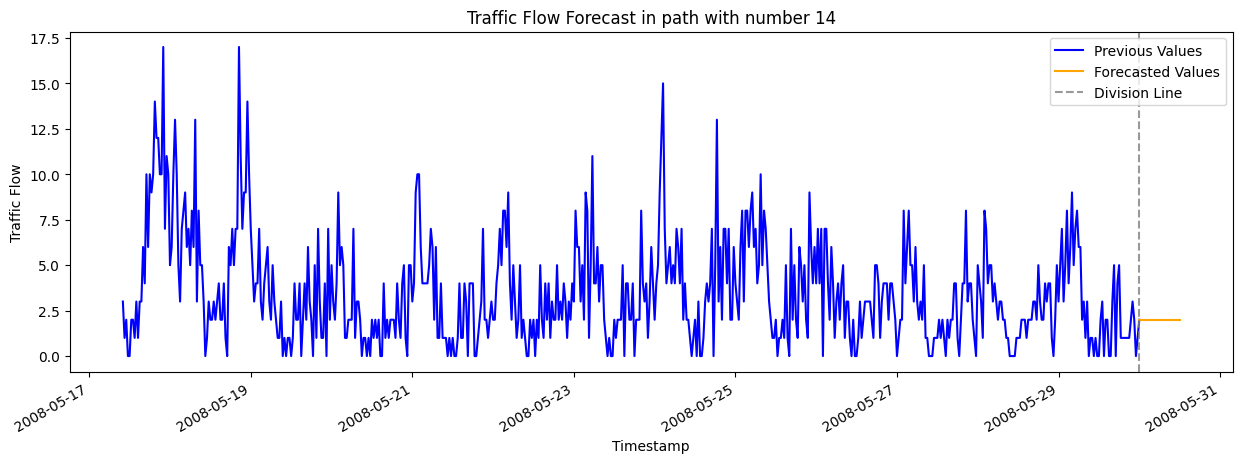

In [62]:
# Plot actual and predicted values of traffic flow in path with number 14
plot_actual_predicted(14)

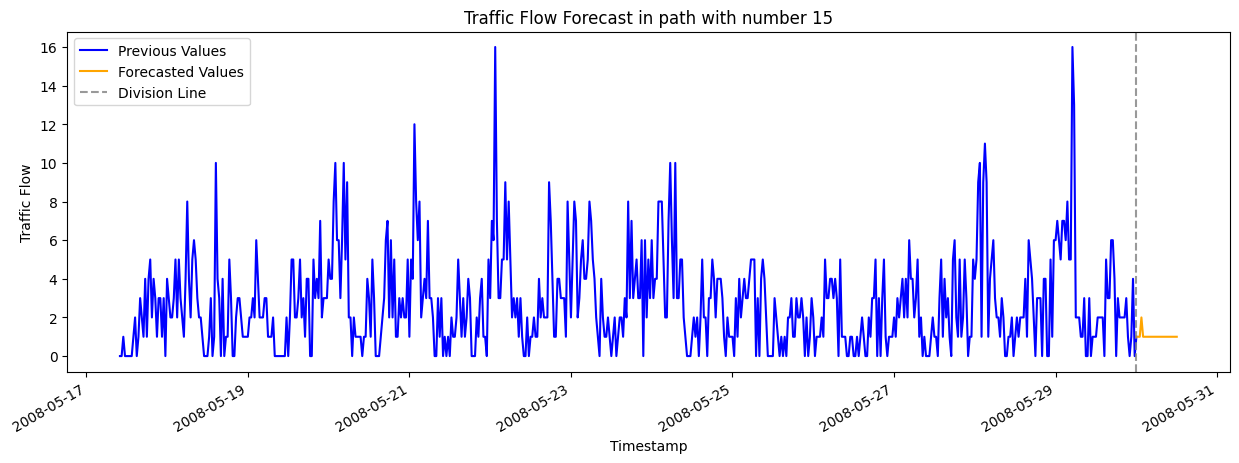

In [63]:
# Plot actual and predicted values of traffic flow in path with number 15
plot_actual_predicted(15)

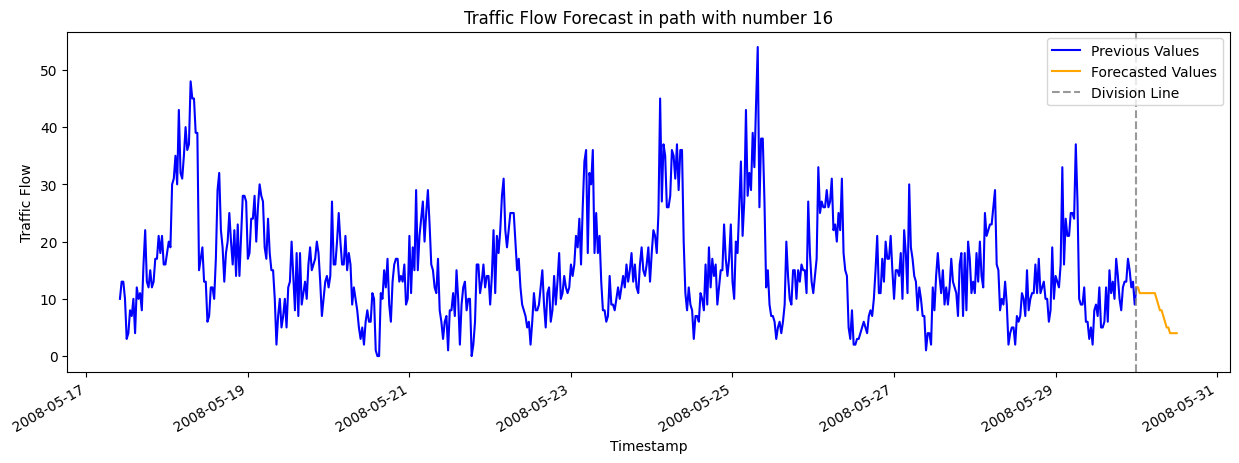

In [64]:
# Plot actual and predicted values of traffic flow in path with number 16
plot_actual_predicted(16)

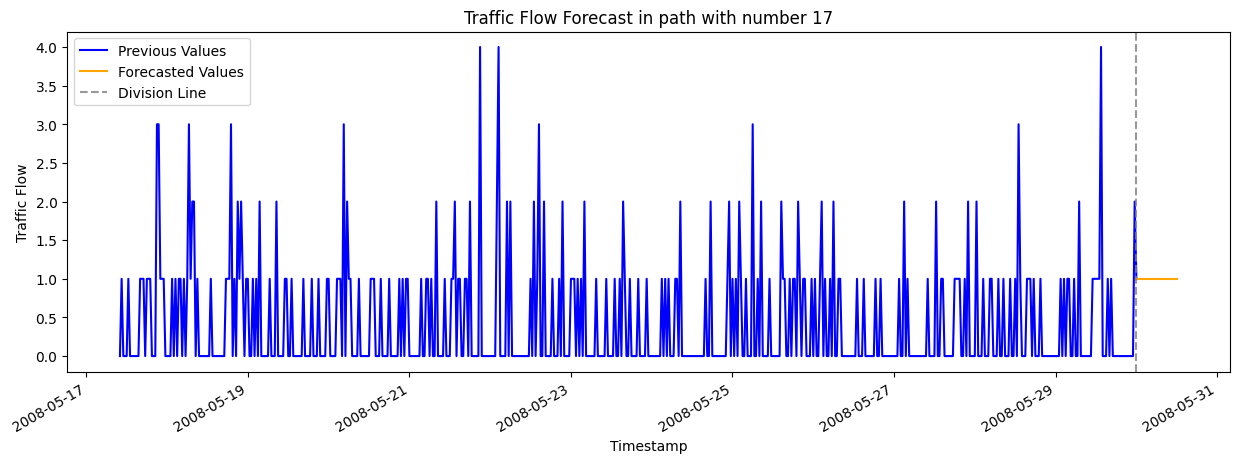

In [65]:
# Plot actual and predicted values of traffic flow in path with number 17
plot_actual_predicted(17)

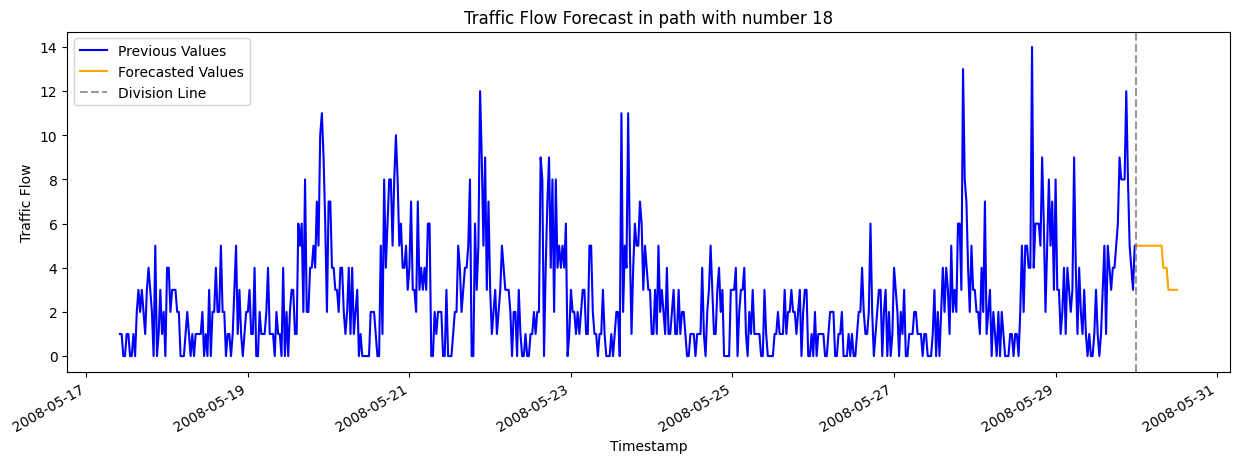

In [66]:
# Plot actual and predicted values of traffic flow in path with number 18
plot_actual_predicted(18)

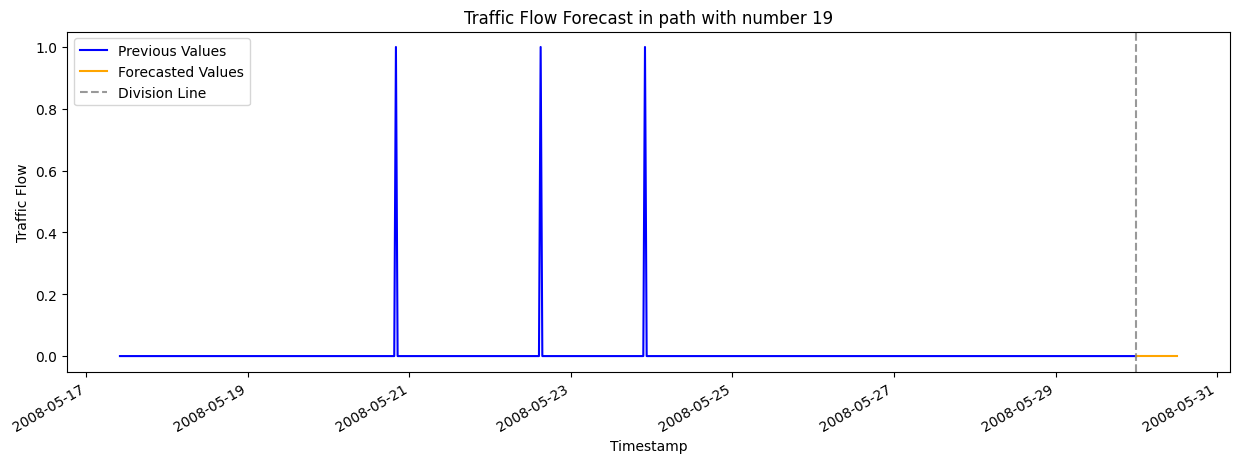

In [67]:
# Plot actual and predicted values of traffic flow in path with number 19
plot_actual_predicted(19)